In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
plt.style.use('seaborn')

In [9]:
from scipy.misc import comb
from scipy.special import beta
def pdf(x, a, b, n):
    return [comb(n, xi) * beta(xi+a, n-xi+b) / beta(a, b) for xi in x]

In [10]:
i = range(10)
a_prior = 2
b_prior = 3
n_prior = 10

prior = pdf(i, a_prior, b_prior, n_prior)

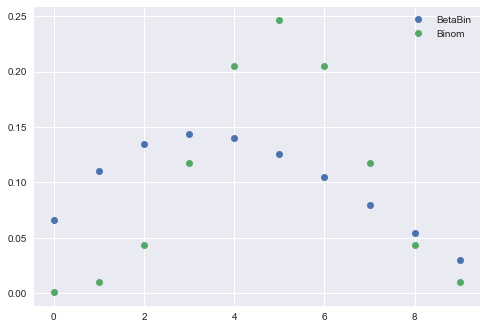

In [22]:
plt.plot(i, prior, 'o', label='BetaBin')
plt.plot(i, stats.binom.pmf(i, p=.5, n=10), 'o', label='Binom')
plt.legend();

In [24]:
def pdf_2(x, eta, k, n):
    a = eta * k
    b = k * (1 - eta)
    return pdf(x, a, b, n)

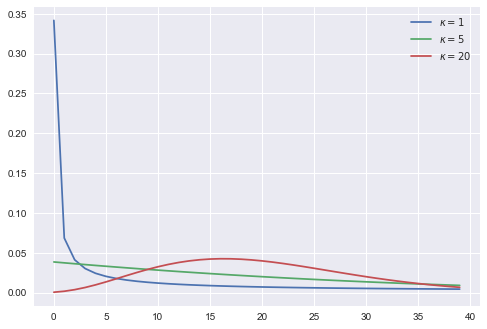

In [38]:
i = range(40)
eta_prior = .2
k_priors = [1, 5, 20]
n_prior = 100

[plt.plot(i, pdf_2(i, eta_prior, k, n_prior), '-', label=rf'$\kappa={k}$') for k in k_priors]
plt.legend()

In [91]:
def posterior(n, y, eta0, k0):
    p1 = 1 / (eta0*(1 - eta0))
    p2 = 1 / (1 + k0)**2
    a = k0 * eta0
    b = k0 * (1 - eta0)
    return np.prod([beta(a + yi, b + ni - yi) / beta(a, b) for ni, yi in zip(n, y)], axis=0)

In [92]:
data = pd.DataFrame()
data['y'] = [0, 0, 2, 0, 1, 1]
data['n'] = [1083, 855, 3461, 657, 1208, 1025]
data['prop'] = data.y / data.n
data

,y,n,prop
0,0,1083,0.000000
1,0,855,0.000000
2,2,3461,0.000578
3,0,657,0.000000
4,1,1208,0.000828
5,1,1025,0.000976


In [106]:
lims = (.0001, 0.003, 1, 30000)
etas = np.linspace(*lims[:2])
ks = np.linspace(*lims[2:])
ev, kv = np.meshgrid(etas, ks, sparse=True)
res = posterior(data.n, data.y, ev, kv)

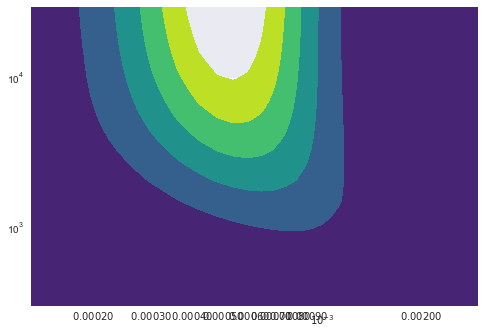

In [107]:
plt.contourf(res, cmap='viridis', origin='lower', extent=lims)
plt.xscale('logit')
plt.yscale('log')

In [99]:
def posterior_2(n, y, logitEta, logK):
    eta = np.exp(logitEta) / (np.exp(logitEta) + 1)
    k = np.exp(logK)
    return posterior(n, y, eta, k)

In [103]:
lims2 = (-8, 4.5, 4, 20)
lie = np.linspace(*lims2[:2])
lk = np.linspace(*lims2[2:])
lev, lkv = np.meshgrid(lie, lk, sparse=True)

res2 = posterior_2(data.n, data.y, lev, lkv)

C:\Users\miles\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


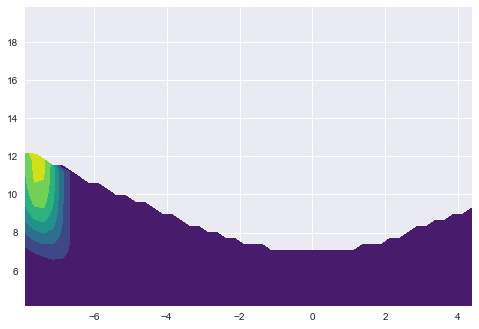

In [104]:
plt.contourf(res2, cmap='viridis', origin='lower', extent=lims2)

In [117]:
from scipy import optimize
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [118]:
params = fitgaussian(res)
fit = gaussian(*params)

TypeError: float() argument must be a string or a number, not 'function'

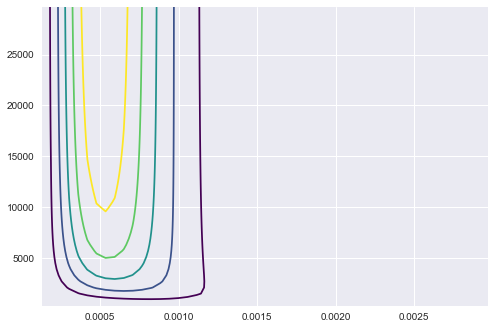

In [119]:
plt.contour(res, cmap='viridis', origin='lower', extent=lims)
plt.contour(fit, origin='lower', extent=lims)
plt.xscale('logit')
plt.yscale('log')